In [135]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
import os
import string
import io
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

2.1.0-rc1


In [136]:
DIR_NAMES = ['train-easy/']
FILE_NAMES = ['numbers__place_value.txt']

BUFFER_SIZE = 50000

current_dir = os.getcwd()
dataset_dir = './Dataset'

# Based on https://www.tensorflow.org/tutorials/load_data/text
# Read in all files which are in FILE_NAMES
labeled_data_sets = []

for file_name in FILE_NAMES:
    for dir_name in DIR_NAMES:
        concat_dir = os.path.join(dir_name, file_name)
        lines_dataset = io.open(os.path.join(dataset_dir, concat_dir), encoding='UTF-8').read().strip().split('\n')
        labeled_data_sets.append(lines_dataset)
        
# Concatenate all File Data to one Big File Data
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
 
x_labels = all_labeled_data[::2]
y_labels = all_labeled_data[1::2]

MAX_QUESTION_LENGTH = 160
MAX_ANSWER_LENGTH = 2

QUESTION_CHARS = ( ['', ' '] + list(string.ascii_letters + string.digits + string.punctuation))
CHAR_TO_INDEX = {char: index for index, char in enumerate(QUESTION_CHARS)}
INDEX_TO_CHAR = {index: char for index, char in enumerate(QUESTION_CHARS)}

NUM_INDICES = len(QUESTION_CHARS)

x_labels_encoded = [[CHAR_TO_INDEX[z] for z in sentence] for sentence in x_labels]
y_labels_encoded = [[CHAR_TO_INDEX[z] for z in sentence] for sentence in y_labels]

print(CHAR_TO_INDEX)

{'': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'M': 40, 'N': 41, 'O': 42, 'P': 43, 'Q': 44, 'R': 45, 'S': 46, 'T': 47, 'U': 48, 'V': 49, 'W': 50, 'X': 51, 'Y': 52, 'Z': 53, '0': 54, '1': 55, '2': 56, '3': 57, '4': 58, '5': 59, '6': 60, '7': 61, '8': 62, '9': 63, '!': 64, '"': 65, '#': 66, '$': 67, '%': 68, '&': 69, "'": 70, '(': 71, ')': 72, '*': 73, '+': 74, ',': 75, '-': 76, '.': 77, '/': 78, ':': 79, ';': 80, '<': 81, '=': 82, '>': 83, '?': 84, '@': 85, '[': 86, '\\': 87, ']': 88, '^': 89, '_': 90, '`': 91, '{': 92, '|': 93, '}': 94, '~': 95}


In [137]:
print(x_labels[0])
print(x_labels_encoded[0])
print(y_labels[0])
print(y_labels_encoded[0])
print(x_labels[1])
print(x_labels_encoded[1])
print(len(y_labels_encoded))

What is the hundreds digit of 31253?
[50, 9, 2, 21, 1, 10, 20, 1, 21, 9, 6, 1, 9, 22, 15, 5, 19, 6, 5, 20, 1, 5, 10, 8, 10, 21, 1, 16, 7, 1, 57, 55, 56, 59, 57, 84]
2
[56]
What is the units digit of 8196?
[50, 9, 2, 21, 1, 10, 20, 1, 21, 9, 6, 1, 22, 15, 10, 21, 20, 1, 5, 10, 8, 10, 21, 1, 16, 7, 1, 62, 55, 63, 60, 84]
666666


In [0]:
#Padding the Input Questions and Output Answers to the right length
x_labels_padded = tf.keras.preprocessing.sequence.pad_sequences(x_labels_encoded, maxlen=MAX_QUESTION_LENGTH, value = 0, padding='post')
y_labels_padded = tf.keras.preprocessing.sequence.pad_sequences(y_labels_encoded, maxlen=MAX_ANSWER_LENGTH, value = 0, padding='post')

In [139]:
print(x_labels_padded[0])
print(y_labels_padded[0])
print(len(x_labels_padded))
print(len(y_labels_padded))

[50  9  2 21  1 10 20  1 21  9  6  1  9 22 15  5 19  6  5 20  1  5 10  8
 10 21  1 16  7  1 57 55 56 59 57 84  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[56  0]
666666
666666


In [0]:
TAKE_SIZE = 100000
BUFFER_SIZE = 50000
BATCH_SIZE = 128
embedding_dim = 256
steps_per_epoch = TAKE_SIZE//BATCH_SIZE
units = 512

vocab_inp_size = NUM_INDICES
vocab_tar_size = NUM_INDICES

dataset = tf.data.Dataset.from_tensor_slices((x_labels_padded, y_labels_padded)).take(TAKE_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [141]:
print(steps_per_epoch)

781


In [142]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 160]), TensorShape([128, 2]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [145]:
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 160, 512)
Encoder Hidden state shape: (batch size, units) (128, 512)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [147]:
attention_layer = BahdanauAttention(10)

attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 512)
Attention weights shape: (batch_size, sequence_length, 1) (128, 160, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [149]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 96)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  #mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  #mask = tf.cast(mask, dtype=loss_.dtype)
  #loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './numbers__place_value_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([CHAR_TO_INDEX['']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t-1], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t-1], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [153]:
TRAIN_FROM_CHECKPOINT = 1
latest_checkpoint_dir = './numbers__place_value_checkpoints'
if(TRAIN_FROM_CHECKPOINT):
    # restoring the latest checkpoint in checkpoint_dir
    checkpoint.restore(tf.train.latest_checkpoint(latest_checkpoint_dir))


EPOCHS = 2

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every epochs

  checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0008
Epoch 1 Batch 100 Loss 0.0004
Epoch 1 Batch 200 Loss 0.0246
Epoch 1 Batch 300 Loss 0.0007
Epoch 1 Batch 400 Loss 0.0005
Epoch 1 Batch 500 Loss 0.0004
Epoch 1 Batch 600 Loss 0.0002
Epoch 1 Batch 700 Loss 0.0004
Epoch 1 Loss 0.0013
Time taken for 1 epoch 62.45381736755371 sec

Epoch 2 Batch 0 Loss 0.0001
Epoch 2 Batch 100 Loss 0.0001
Epoch 2 Batch 200 Loss 0.0017
Epoch 2 Batch 300 Loss 0.0015
Epoch 2 Batch 400 Loss 0.0002
Epoch 2 Batch 500 Loss 0.0002
Epoch 2 Batch 600 Loss 0.0000
Epoch 2 Batch 700 Loss 0.0001
Epoch 2 Loss 0.0030
Time taken for 1 epoch 63.381850242614746 sec



In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  inputs = [[CHAR_TO_INDEX[z] for z in sentence]]
    
  print(inputs)
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen=max_length_inp,
                                                         value=0,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([CHAR_TO_INDEX['']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += INDEX_TO_CHAR[predicted_id] #+ ' '

    if INDEX_TO_CHAR[predicted_id] == '':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

  attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
  plot_attention(attention_plot, list(sentence), list(result))

In [157]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()

checkpoint_dir = './numbers__place_value_checkpoints'
#checkpoint_dir = './arithmetic__add_or_sub_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

max_length_targ = MAX_ANSWER_LENGTH
max_length_inp = MAX_QUESTION_LENGTH
vocab_inp_size = NUM_INDICES
vocab_tar_size = NUM_INDICES

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

What is the hundreds digit of 31253?
tf.Tensor([56  0], shape=(2,), dtype=int32)
[[50, 9, 2, 21, 1, 10, 20, 1, 21, 9, 6, 1, 22, 15, 10, 21, 20, 1, 5, 10, 8, 10, 21, 1, 16, 7, 1, 56, 58, 59, 62, 58, 84]]
Input: What is the units digit of 24584?
Predicted translation: 44


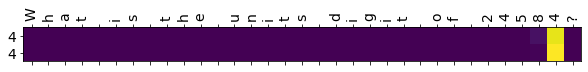

What is the units digit of 8196?
tf.Tensor([60  0], shape=(2,), dtype=int32)
[[50, 9, 2, 21, 1, 10, 20, 1, 21, 9, 6, 1, 22, 15, 10, 21, 20, 1, 5, 10, 8, 10, 21, 1, 16, 7, 1, 56, 58, 59, 62, 58, 84]]
Input: What is the units digit of 24584?
Predicted translation: 44


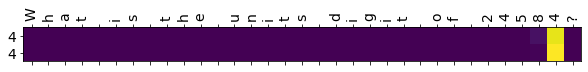

What is the ten thousands digit of 37118?
tf.Tensor([57  0], shape=(2,), dtype=int32)
[[50, 9, 2, 21, 1, 10, 20, 1, 21, 9, 6, 1, 22, 15, 10, 21, 20, 1, 5, 10, 8, 10, 21, 1, 16, 7, 1, 56, 58, 59, 62, 58, 84]]
Input: What is the units digit of 24584?
Predicted translation: 44


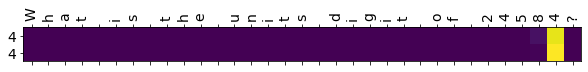

What is the hundreds digit of 1229?
tf.Tensor([56  0], shape=(2,), dtype=int32)
[[50, 9, 2, 21, 1, 10, 20, 1, 21, 9, 6, 1, 22, 15, 10, 21, 20, 1, 5, 10, 8, 10, 21, 1, 16, 7, 1, 56, 58, 59, 62, 58, 84]]
Input: What is the units digit of 24584?
Predicted translation: 44


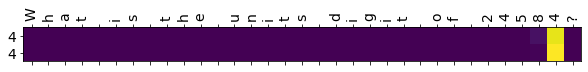

What is the units digit of 834?
tf.Tensor([58  0], shape=(2,), dtype=int32)
[[50, 9, 2, 21, 1, 10, 20, 1, 21, 9, 6, 1, 22, 15, 10, 21, 20, 1, 5, 10, 8, 10, 21, 1, 16, 7, 1, 56, 58, 59, 62, 58, 84]]
Input: What is the units digit of 24584?
Predicted translation: 44


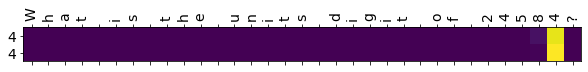

In [163]:
count = 0
for indx, x in enumerate(x_labels):
  print(x)
  print(y[indx])
  translate(x)

  count = count + 1
  if(count == 5):
    break

In [166]:
from google.colab import files
!zip -r numbers__place_value_checkpoints.zip ./numbers__place_value_checkpoints

updating: numbers__place_value_checkpoints/ (stored 0%)
updating: numbers__place_value_checkpoints/ckpt-1.index (deflated 70%)
updating: numbers__place_value_checkpoints/ckpt-3.index (deflated 70%)
updating: numbers__place_value_checkpoints/checkpoint (deflated 38%)
updating: numbers__place_value_checkpoints/ckpt-2.index (deflated 70%)
updating: numbers__place_value_checkpoints/ckpt-3.data-00000-of-00002 (deflated 60%)
updating: numbers__place_value_checkpoints/ckpt-2.data-00001-of-00002 (deflated 20%)
updating: numbers__place_value_checkpoints/ckpt-3.data-00001-of-00002 (deflated 20%)
updating: numbers__place_value_checkpoints/ckpt-4.data-00001-of-00002 (deflated 20%)
updating: numbers__place_value_checkpoints/ckpt-2.data-00000-of-00002 (deflated 60%)
updating: numbers__place_value_checkpoints/ckpt-1.data-00000-of-00002 (deflated 60%)
updating: numbers__place_value_checkpoints/ckpt-4.index (deflated 70%)
updating: numbers__place_value_checkpoints/ckpt-1.data-00001-of-00002 (deflated 2